In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib.widgets import Slider, Button
import scipy
import scipy.optimize
import scipy.io
from scipy.interpolate import interp1d
import nmrglue as ng
import pandas as pd
#also requires openpyxl

from cops_analysis import cops_analyze

In [2]:
%%time 
import os
os.chdir('/home/nmrbox/hwang/Documents/COPS_dev/no_pyruvate/')
a = cops_analyze(['GB1_BCG1.ucsf','GB1_BCG3.ucsf','GB1_BCG4.ucsf','GB1_BCG5.ucsf','GB1_BCG6.ucsf',], mode='HCA',pyruvate_on=False)


CPU times: user 4.91 ms, sys: 2.24 ms, total: 7.15 ms
Wall time: 16.6 ms


In [3]:
tb=pd.read_fwf('GB1_BCG1.list', infer_nrows=300)
tb = tb.rename(columns={'w1':'CA','w2':'HN'})

#realign spectra
tb = tb.set_index(tb['Assignment'])
tb = tb.drop(columns='Assignment')

shifts_array = tb.to_numpy(dtype=np.float32)
tb

,CA,HN
Assignment,,
T1Ca-HN,52.978,8.284
T1Ca-Y2HN,52.978,9.048
Y2Ca-HN,54.261,9.048
Y2Ca-K3HN,54.261,9.048
K3Ca-HN,52.176,9.047
...,...,...
V53Ca-HN,55.099,8.179
V53Ca-T54HN,55.089,8.303
T54Ca-HN,57.846,8.304


In [14]:
a.CalcCB(shifts_array[7], simple_output=False)

(array([ 6.29099292,  0.999     , 39.15247186,  3.8223043 , 54.97387795,
         9.14082476]),
 0.09489301845432563)

In [4]:
%%time
CBs = []
credence = []

for i in range(len(shifts_array)):
    try: 
        result = a.CalcCB(shifts_array[i], simple_output=False)
    except:
        result = ([0,0,0,0,0],[1])
    CBs = np.append(CBs, result[0][2])
    credence = np.append(credence, result[1])
tb['CB'] = CBs
tb['1/covariance'] = 1/credence

CPU times: user 42.6 s, sys: 357 ms, total: 43 s
Wall time: 43.3 s


In [5]:
tb

,CA,HN,CB,1/covariance
Assignment,,,,
T1Ca-HN,52.978,8.284,27.330293,6.878374
T1Ca-Y2HN,52.978,9.048,27.131355,4.908550
Y2Ca-HN,54.261,9.048,39.950039,13.657712
Y2Ca-K3HN,54.261,9.048,39.950039,13.657712
K3Ca-HN,52.176,9.047,32.394571,10.822657
...,...,...,...,...
V53Ca-HN,55.099,8.179,28.863622,4.908015
V53Ca-T54HN,55.089,8.303,28.864995,5.835914
T54Ca-HN,57.846,8.304,45.178455,5.172885


In [6]:
tb_truth = pd.read_excel('GB1_ground_truth_hw.xlsx')

In [7]:
tb['CB_scott'] = tb_truth['CB_scott'].to_numpy()
tb.to_excel('CB_fit_results_nopyruvate.xlsx')

## DEV

In [69]:
def extract1D(data_pt_ppm, spectrum, uc, sw=100.1, C_offset = 0, normalize=False):

    #convert data_pt_ppm to index

    if a.mode=='HNCA':

        idx = np.array([uc[0](data_pt_ppm[0], "ppm"), uc[1](data_pt_ppm[1]+C_offset, "ppm"), uc[2](data_pt_ppm[2], "ppm")])
        #calculate indices for trace boundary, based on tw. 
        hz_bounds = a.hz_to_idx(uc[1], sw)
        hz_vals = np.linspace(-hz_bounds, hz_bounds, num=2*hz_bounds+1)*sw/hz_bounds

        #1D slice through peak center, weight-added by tensor product to 1D 13C slices nearby (in the HN, N dimensions)
        weights = np.array([[0.6, 0.8, 0.9, 1, 0.9, 0.8, 0.6]]) #weights vector to compute weighted sum
        slices = spectrum[idx[0]-3:idx[0]+4, idx[1]-hz_bounds:idx[1]+hz_bounds+1,idx[2]-3:idx[2]+4]
        trace = np.tensordot(slices,weights.T@weights, axes=([0,2],[0,1]))
        trace = np.array(trace)
    elif a.mode=='HCA':
        idx = np.array([uc[i](data_pt_ppm[i], "ppm") for i in range(len(uc))])
        #calculate indices for trace boundary, based on tw. 
        hz_bounds = a.hz_to_idx(uc[0], sw)
        hz_vals = np.linspace(-hz_bounds, hz_bounds, num=2*hz_bounds+1)*sw/hz_bounds
        #1D slice through peak center, weight-added by tensor product to 1D 13C slices nearby (in the HN, N dimensions)
        weights = np.array([[0.4,0.8,1,0.8,0.4]]) #weights vector to compute weighted sum
        slices = spectrum[idx[0]-hz_bounds:idx[0]+hz_bounds+1, idx[1]-2:idx[1]+3]
        trace = slices@weights.T
        trace = np.array(trace)

    normalizer=np.sum(trace)

    if normalize:
        #normalize by peak volume
        trace=trace/normalizer*(2*hz_bounds+1)
    return hz_vals, trace

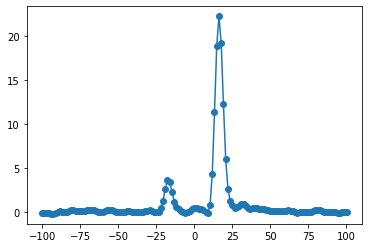

In [78]:
diagnose = shifts_array[0] #18 for K27, #-4 for K49
diagnose = [51.6, 8.21]
hz, nocop_trace= extract1D(diagnose, a.cop_dats[0], a.cop_unit_convs[0], normalize=True)
plt.plot(hz, nocop_trace, '-o')

In [11]:
data = shifts_array[1]
params,_ = a.CalcCB(data, simple_output=False)
print([(1+a.dec_interpolation[i](params[2]))/2 for i in range(5)])
print(params)
print(params[2])

[0.99922562202695, 0.6164240778049888, 0.9972319609911423, 0.9895554077368358, 0.9993142517251683]
[39.99999996  1.         42.9851771  24.56666616 34.80521586  8.483489  ]
42.985177100820835


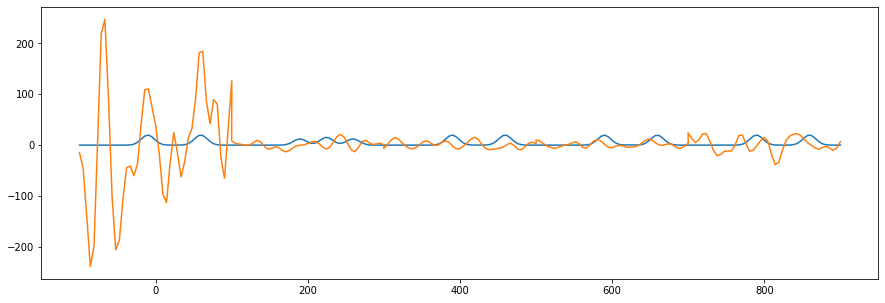

In [12]:
hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)[1] for i in range(5)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(5)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, a.lineshape_Cb(hz, *params), hz_long, cop_1Ds)